Illustrate some properties of random matrices mentioned in [https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.97.188104] by Kanaka Rajan and Larry Abbott

Numerical experiments

In [138]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import random
import time
from scipy.stats import gaussian_kde


In [139]:
# Illustration purpose

N = 1000
alpha = 0.06
mu_E = 0.3
mu_I = -0.7
f = 0.7

var_E = 1/(N*alpha)
var_I = 1/N

# assert abs(f * mu_E + (1 - f) * mu_I - 0.0) < 1e-10
# assert mu_E / np.sqrt(N) > 0
# assert mu_I / np.sqrt(N) < 0
# sampled_column = np.random.choice(range(N), int(f*N), replace=False)

# W = np.zeros((N, N))
# for i in range(N):
#     if i in sampled_column:
#         W[i,:] = np.random.normal(mu_E, np.sqrt(var_E), N)
#     else:
#         W[i,:] = np.random.normal(mu_I, np.sqrt(var_I), N)

# eigenvalues_new = np.linalg.eigvals(W)

# r_ind = np.sqrt(1 + f*(mu_E)**2 + (1-f)*mu_I**2)

# theta = np.linspace(0, 2*np.pi, 100)
# x = np.cos(theta) * r_ind
# y = np.sin(theta) * r_ind

# fig, axs = plt.subplots(1,2,figsize=(4*2,4))
# sns.heatmap(W, ax=axs[0], cbar=True, square=True)
# axs[1].plot(x, y, color='red', linewidth=2, label='Unit Circle')
# axs[1].scatter(eigenvalues_new.real, eigenvalues_new.imag, s=50)
# axs[1].grid(True)
# axs[1].legend()
# axs[1].axis('equal') 
# plt.show()

def data_generator(N, f, alpha):
    assert 0 < f and f < 1
    mu_E = 1-f
    mu_I = -f
    var_E = 1 / (N*alpha)
    var_I = 1 / N
    assert abs(f * mu_E + (1 - f) * mu_I - 0.0) < 1e-10
    assert mu_E / np.sqrt(N) > 0
    assert mu_I / np.sqrt(N) < 0
    sampled_column = np.random.choice(range(N), int(f*N), replace=False)

    W = np.zeros((N, N))
    for i in range(N):
        if i in sampled_column:
            W[i,:] = np.random.normal(mu_E, np.sqrt(var_E), N)
        else:
            W[i,:] = np.random.normal(mu_I, np.sqrt(var_I), N)

    # Equation 2 constraints
    # adjust = np.mean(W, axis=1)
    # for i in range(len(adjust)):
    #     W[:,i] -= adjust
            
    W -= np.mean(W, axis=1, keepdims=True)

    return W

# r_normal = np.sqrt(1+f*(mu_E**2)+(1-f)*(mu_I)**2)
# print(r_normal)

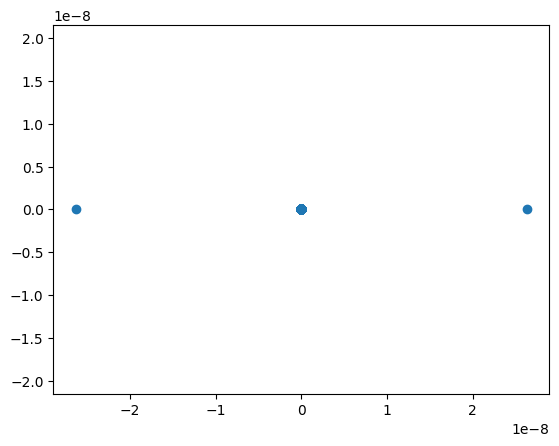

In [140]:
m1 = np.array([mu_E for _ in range(int(f*N))])
m2 = np.array([mu_I for _ in range(int((1-f)*N))])
m = np.concatenate((m1, m2))
m = 1 / np.sqrt(N) * m
M = np.tile(m, (N, 1))

eigenvalues_shift = np.linalg.eigvals(M)
plt.figure()
plt.scatter(eigenvalues_shift.real, eigenvalues_shift.imag)
plt.axis('equal') 
plt.show()

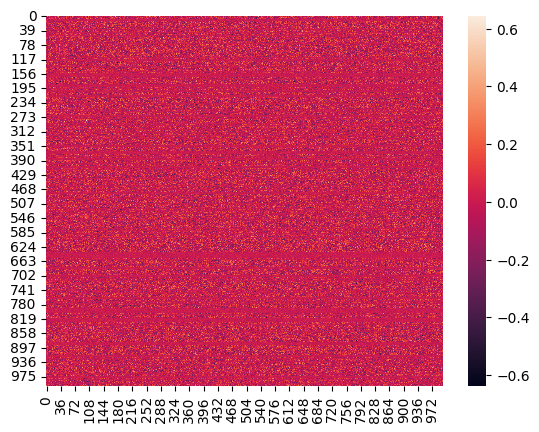

r2: 3.459287017098562
r2_eqv: 3.459287017098562
r2_high: 0.9999999999999999


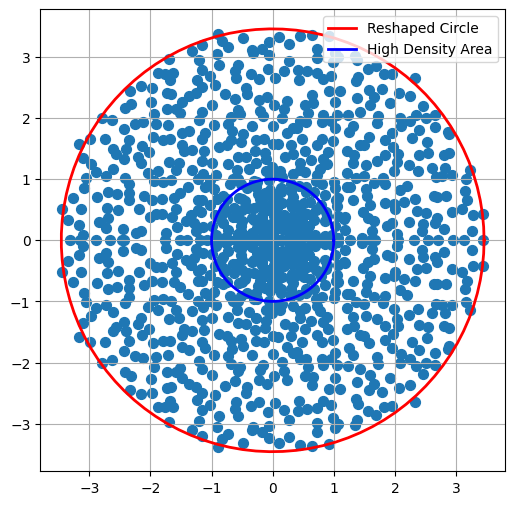

/var/folders/xw/612lbhl95cx1vbrp3tfqjjlw0000gn/T/ipykernel_72254/3542403706.py:37: RuntimeWarning: divide by zero encountered in divide
  normalize_W = W / W_sum[:, np.newaxis]


LinAlgError: Array must not contain infs or NaNs

In [141]:
# Apply Equation 2 constraint
W = data_generator(N=N, f=f, alpha=alpha)

plt.figure()
sns.heatmap(W)
plt.show()

eigenvalues_shift = np.linalg.eigvals(W)

r2 = np.sqrt(1 - f + f/alpha)
print(f"r2: {r2}")
r2_eqv = np.sqrt(N * (f*var_E + (1-f)*var_I))
print(f"r2_eqv: {r2_eqv}")
r2_high = np.sqrt(N) * np.min([np.sqrt(var_E), np.sqrt(var_I)])
print(f"r2_high: {r2_high}")

theta = np.linspace(0, 2*np.pi, 100)
x = np.cos(theta) * r2
y = np.sin(theta) * r2

x_in = np.cos(theta) * r2_high
y_in = np.sin(theta) * r2_high

plt.figure(figsize=(6, 6))
plt.plot(x, y, color='red', linewidth=2, label='Reshaped Circle')
plt.plot(x_in, y_in, color='blue', linewidth=2, label='High Density Area')
plt.scatter(eigenvalues_shift.real, eigenvalues_shift.imag, s=50)
plt.grid(True)
plt.legend()
plt.axis('equal') 
plt.show()

eigen_data = np.array([eigenvalues_shift.real, eigenvalues_shift.imag]).T
eigen_data_norm = np.sqrt(eigen_data[:,0] ** 2 + eigen_data[:,1] ** 2)

Theoretical Analysis

In [ ]:
# Equation 14
def q_dashed(norm_w, alpha, f, r):
    stepI = (1-alpha)/(2*(1-f))
    stepII = ((1-alpha)*(norm_w ** 2) - 1 + 2*f)
    stepIII = np.sqrt(((1-alpha)*(norm_w ** 2)-1)**2 + 4*f*(1-alpha)*(norm_w**2))
    return stepI * (1 + stepII / stepIII) * (norm_w <= r)

def q_dashed_twice(norm_w, alpha, f, r):
    stepI = ((1-alpha)**2)/(2*(1-f)*np.sqrt(((1-alpha)*(norm_w**2)-1)**2 + 4*f*(1-alpha)*(norm_w**2)))
    stepII = ((1-alpha)*(norm_w**2)-1+2*f)**2
    stepIII = ((1-alpha)*(norm_w**2)-1)**2 + 4*f*(1-alpha)*(norm_w**2)
    return stepI * (1 - stepII/stepIII) * (norm_w <= r)

# Equation 11
def q(norm_w, alpha, f, r):
    stepI = (1-alpha)*(norm_w**2)+2*f-1
    stepII = 2*(1-f)
    stepIII = np.sqrt(((1-alpha)*(norm_w**2)-1)**2) + 4*f*(1-alpha)*(norm_w**2)
    stepIV = 2*(1-f)
    return stepI/stepII + stepIII/stepIV * (norm_w <= r)

# Equation 13
def phi_dashed(norm_w, alpha, f, r):
    q_dashed_val = q_dashed(norm_w, alpha, f, r)
    q_val = q(norm_w, alpha, f, r)
    stepI = 1/(q_val+1)-f/q_val+(alpha*(norm_w ** 2))/(q_val+1) - ((norm_w**2)*(alpha*q_val+1))/((q_val+1)**2)
    stepII = (alpha*q_val+1)/(q_val+1)
    return q_dashed_val*stepI+stepII * (norm_w <= r)

def phi_dashed_twice(norm_w, alpha, f, r):
    q_dashed_twice_val = q_dashed_twice(norm_w, alpha, f, r)
    q_dashed_val = q_dashed(norm_w, alpha, f, r)
    q_val = q(norm_w, alpha, f, r)
    stepI = q_dashed_twice_val*(1/(q_val+1)-f/q_val+(alpha*(norm_w**2))/(q_val+1)-((norm_w**2)*(alpha*q_val+1))/((q_val+1)**2))
    stepII = 2*q_dashed_val*(alpha/(q_val+1)-(alpha*q_val+1)/((q_val+1)**2))
    stepIII = (q_dashed_val**2)*(-1/((q_val+1)**2)+f/((q_val)**2)-(2*alpha*(norm_w**2))/((q_val+1)**2)+(2*(norm_w**2)*(alpha*q_val+1))/((q_val+1)**3))
    return stepI + stepII + stepIII * (norm_w <= r)

# cut-off radius
def r_cal(N, f, alpha):
    var_E = 1/(N*alpha)
    var_I = 1/N
    r = np.sqrt(N * (f*var_E + (1-f)*var_I))
    return r

# Equation 3
def rho(N, norm_w, f, alpha):
    r = r_cal(N, f, alpha)
    stepI = (norm_w**2)*phi_dashed_twice(norm_w, alpha, f, r) + phi_dashed(norm_w, alpha, f, r)
    return 1 / np.pi * stepI

def cal_density_experiment(w_range, eigen_data_norm):
    density_count = []
    for w_norm in w_range:
        count = np.sum(eigen_data_norm < w_norm)
        area = np.pi * (w_norm ** 2)
        density_count.append(count / area)
    return density_count

/var/folders/xw/612lbhl95cx1vbrp3tfqjjlw0000gn/T/ipykernel_72254/2028555007.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/xw/612lbhl95cx1vbrp3tfqjjlw0000gn/T/ipykernel_72254/2028555007.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figshow.show()
) missing from current font.orge/base/envs/uwzihan/lib/python3.9/site-packages/IPython/core/events.py:93: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from current font.orge/base/envs/uwzihan/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


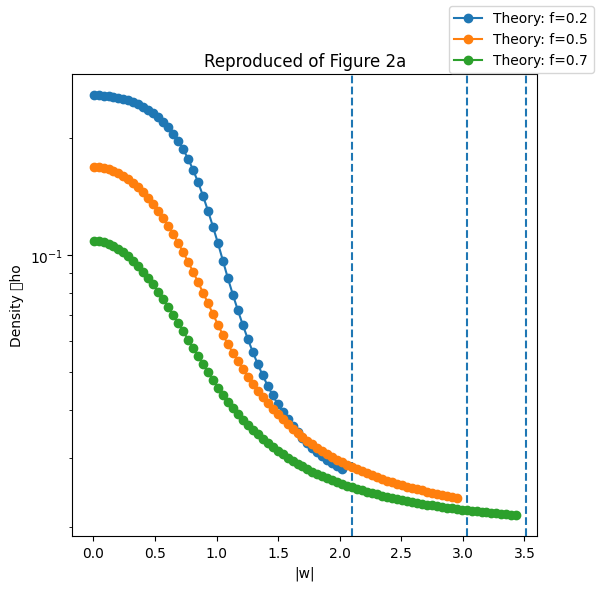

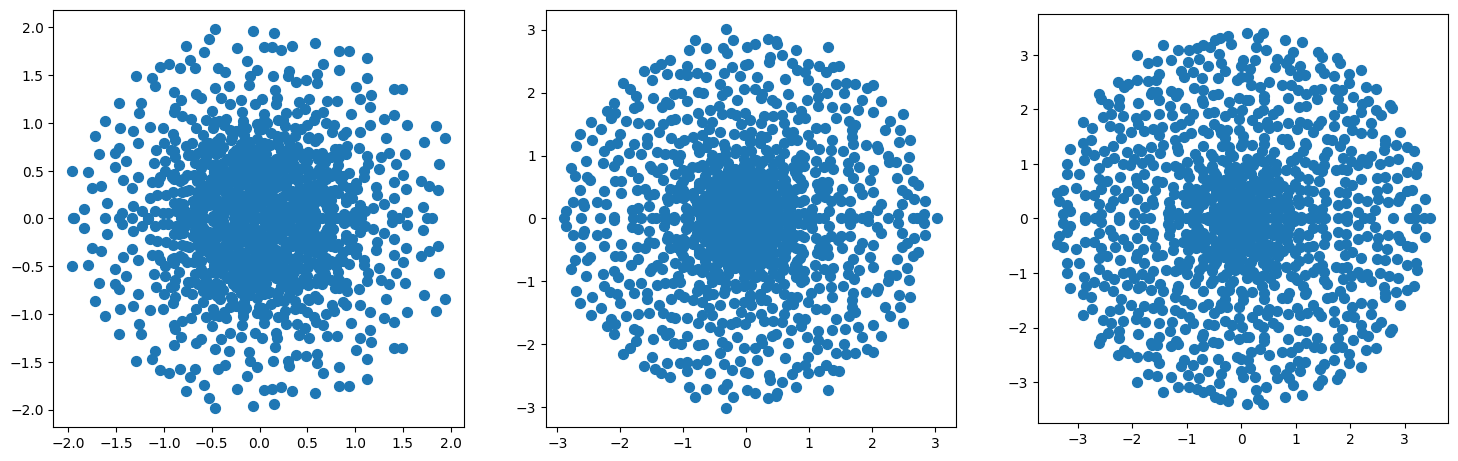

In [ ]:
alpha = 0.06
normw_lst = np.linspace(0.001,4,100)
f_lst = [0.2, 0.5, 0.7]

fig, ax = plt.subplots(1,1,figsize=(6,6))
figshow, axshow = plt.subplots(1,3,figsize=(3*6,6))

for f in f_lst:
    # Experiments
    W = data_generator(N=N, f=f, alpha=0.06)
    eigenvalues_shift = np.linalg.eigvals(W)
    eigen_data = np.array([eigenvalues_shift.real, eigenvalues_shift.imag]).T
    eigen_data_norm = np.sqrt(eigen_data[:,0] ** 2)

    axshow[f_lst.index(f)].scatter(eigen_data[:,0], eigen_data[:,1], s=50)
    axshow[f_lst.index(f)].set_aspect("equal")

    # kde = gaussian_kde(eigen_data_norm)
    # x_vals = np.linspace(min(eigen_data_norm), max(eigen_data_norm), 1000)
    # pdf = kde(x_vals) 

    # density_count = cal_density_experiment(normw_lst, eigen_data_norm)
    # Theory    
    rho_lst = rho(N, normw_lst, f, alpha)
    last_non_zero_index = len(rho_lst) - next((i for i, x in enumerate(reversed(rho_lst)) if x), len(rho_lst))
    ax.plot(normw_lst[:last_non_zero_index], rho_lst[:last_non_zero_index], marker='o', linestyle='-',label=f"Theory: f={f}")
    # ax.scatter(x_vals, pdf)
    ax.axvline(normw_lst[last_non_zero_index+1], linestyle="--")
    ax.set_yscale('log')


fig.legend()
ax.set_xlabel("|w|")
ax.set_ylabel("Density \rho")
ax.set_title("Reproduced of Figure 2a")
fig.show()
figshow.show()

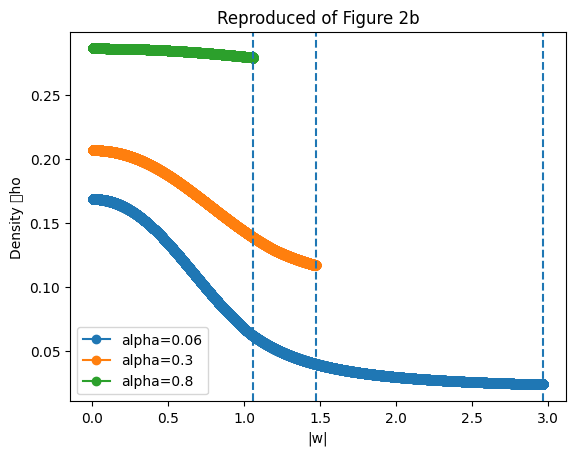

In [ ]:
alpha_lst = [0.06, 0.3, 0.8]
normw_lst = np.linspace(0.001,4,100000)
f = 0.5

plt.figure()
for alpha in alpha_lst:
    rho_lst = rho(N, normw_lst, f, alpha)
    last_non_zero_index = len(rho_lst) - next((i for i, x in enumerate(reversed(rho_lst)) if x), len(rho_lst))
    plt.plot(normw_lst[:last_non_zero_index], rho_lst[:last_non_zero_index], marker='o', linestyle='-',label=f"alpha={alpha}")
    plt.axvline(normw_lst[last_non_zero_index+1], linestyle="--")

plt.legend()
plt.xlabel("|w|")
plt.ylabel("Density \rho")
plt.title("Reproduced of Figure 2b")
plt.show()